# Pathway Analysis with PathSingle

In [1]:
%reload_ext autoreload
%autoreload 2
import scanpy as sc
import pandas as pd
from metrics import *
from activity import *
import scprep
import magic
from warnings import filterwarnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.decomposition import PCA


filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 pynndescent==0.5.13


### Data Preparation
The challenge data is available on AWS cloud servers. You need to register to the challenge here:
- https://www.topcoder.com/challenges/25f60820-2e69-444b-bc03-490686af2c87?tab=details

and then go the the forum links and download sc_training.h5ad from:

- https://discussions.topcoder.com/discussion/25381/challenge-specifications-and-data-for-cancer-immunotherapy-data-science-grand-challenge

In [23]:
adata = sc.read_h5ad('./data/sc_training.h5ad')
#adata = sc.pp.subsample(adata, fraction=0.3, copy=True)
#28697 cells × 15077 genes.
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

adata.X stores the standard-normalized data. We can also reconstruct it using adata.layers['rawcounts'].
- Make a copy of X:
```
    adata.layers['normalized_logcounts'] = adata.X.copy()
```
- Use rawcounts for standard normalization:
```
    adata.X = adata.layers['rawcounts'].copy()
    sc.pp.normalize_total(adata, target_sum=5e3)
    sc.pp.log1p(adata)
    adata.raw.X[:5,:5].toarray()
```
We prefer using rawcounts for magic imputation.

In [18]:
adata.X = adata.layers['rawcounts'].copy()
adata.obs.head()

,gRNA_maxID,state,condition,lane,kmeans3
053l3_GTACTTTGTCGAATCT-1,ONE-NON-GENE-SITE-6,cycling,Unperturbed,lane3,3
053l4_AAGTCTGAGCCAGTTT-1,Ikzf3-3,terminal exhausted,Ikzf3,lane4,1
053l4_TGCACCTCAGCCAGAA-1,Rela-3,effector,Rela,lane4,0
053l3_CCACTACCATCGGTTA-1,Dvl2-3,effector,Dvl2,lane3,0
053l2_CGGTTAAGTGCTCTTC-1,Tox2-3,terminal exhausted,Tox2,lane2,1


### Run Magic
Plot cutoff line.

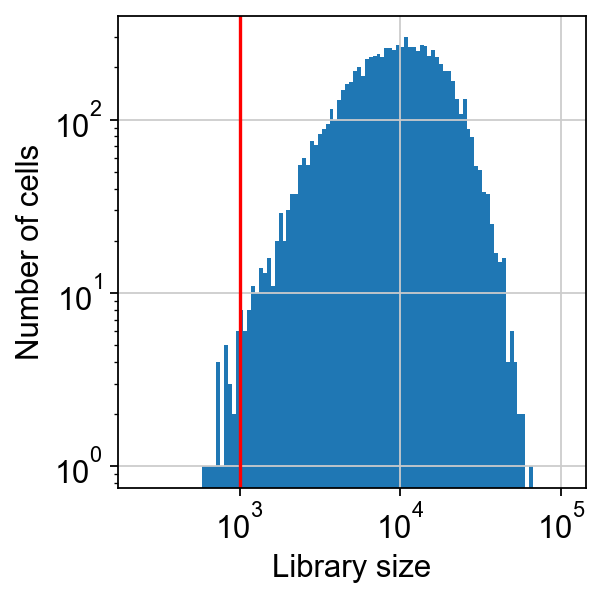

CPU times: total: 1min 50s
Wall time: 2min 2s


<Axes: xlabel='Library size', ylabel='Number of cells'>

In [19]:
%%time
activity_df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
activity_df.to_csv('./data/activity_df.csv', index=True)
emt_data = scprep.io.load_csv('./data/activity_df.csv')
scprep.plot.plot_library_size(emt_data, cutoff=1000)

In [20]:
%%time
emt_data = scprep.filter.filter_library_size(emt_data, cutoff=1000)
emt_data = scprep.normalize.library_size_normalize(emt_data)
emt_data = scprep.transform.sqrt(emt_data)

magic_op = magic.MAGIC()
emt_magic = magic_op.fit_transform(emt_data)
emt_magic.to_csv('./data/emt_magic.csv', index=True)

#sce.pp.magic(adata, name_list='all_genes', knn=5)

Calculating MAGIC...
  Running MAGIC on 8585 cells and 15077 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.77 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.46 seconds.
    Calculating affinities...
    Calculated affinities in 10.11 seconds.
  Calculated graph and diffusion operator in 31.84 seconds.
  Running MAGIC with `solver='exact'` on 15077-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 42.33 seconds.
Calculated MAGIC in 74.91 seconds.
CPU times: total: 9min 38s
Wall time: 4min 51s


### Run PathSingle

In [21]:
cdata = sc.read('./data/emt_magic.csv', delimiter=',', cache=True)
calc_activity(cdata)

... reading from cache file cache\data-emt_magic.h5ad
AnnData object with n_obs × n_vars = 2861 × 15077


100%|██████████| 573/573 [23:50<00:00,  2.50s/it]


### Cluster With KMeans

In [22]:
from sklearn.decomposition import PCA


output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

#Scale the data.
scaler = StandardScaler()
output_activity = scaler.fit_transform(output_activity)
PCA = PCA(n_components=50, svd_solver='arpack')
output_activty = PCA.fit_transform(output_activity)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(output_activity)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(output_activity)

#Add the UMAP coordinates and clustering results to the AnnData object.
cdata.obsm['X_umap'] = umap_coords
cdata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)
cell_state = adata.obs['state']
cdata.obs['state'] = cell_state[emt_magic.index].values #emt_magic

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(cdata, color=["kmeans3"], title="KMeans Clustering on PathSingle Model Values.")
sc.pl.umap(cdata, color=["state"], title="UMAP of True Labels")

ValueError: Length of values (8585) does not match length of index (2861)

In [10]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = output_activity

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

#Special accuracy function. We use cdata.obs.data, the true labels.
print(f"Special accuracy: {acc(cdata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4}), kmeans.labels_)}")
'''
Silhouette Score: 0.13966581225395203
Calinski-Harabasz Index: 4833.945701314397
0.40906714987629367
'''
'''
Silhouette Score: 0.15211382508277893
Calinski-Harabasz Index: 5655.742290248015
Dunn Index: 0.015291933212341749
0.39701014043279786

Silhouette Score: 0.14430435001850128
Calinski-Harabasz Index: 1041.2611092518353
Dunn Index: 0.03004235699635496
Special accuracy: 0.4415403380379857

Silhouette Score: 0.46754899621009827 (without normalization)
Calinski-Harabasz Index: 5878.325061479638
Dunn Index: 0.009056740202426312
Special accuracy: 0.3873497124934658

Silhouette Score: 0.16533960129048486
Calinski-Harabasz Index: 676.7944982873908
Dunn Index: 0.055300375942864
Special accuracy: 0.5340789933589654
'''

Silhouette Score: 0.16533960129048486
Calinski-Harabasz Index: 676.7944982873908
Dunn Index: 0.055300375942864
Special accuracy: 0.5340789933589654
CPU times: total: 5min 31s
Wall time: 5min 30s


'\nSilhouette Score: 0.15211382508277893\nCalinski-Harabasz Index: 5655.742290248015\nDunn Index: 0.015291933212341749\n0.39701014043279786\n\nSilhouette Score: 0.14430435001850128\nCalinski-Harabasz Index: 1041.2611092518353\nDunn Index: 0.03004235699635496\nSpecial accuracy: 0.4415403380379857\n\nSilhouette Score: 0.46754899621009827 (without normalization)\nCalinski-Harabasz Index: 5878.325061479638\nDunn Index: 0.009056740202426312\nSpecial accuracy: 0.3873497124934658\n'

## PROGENy

In [13]:
import decoupler

#top: Desired top number of genes for each pathway according to their significance(p.value). Default to 100.
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [14]:
# Normalize gene names to lowercase.
adata.var_names = [gene.lower() for gene in adata.var_names]
progeny['target'] = progeny['target'].str.lower()

# Inspect unique gene names in both datasets.
unique_adata_genes = set(adata.var_names)
unique_progeny_genes = set(progeny['target'])

# Check overlap.
shared_genes = unique_adata_genes & unique_progeny_genes
print(f"Number of shared genes: {len(shared_genes)}")
print(f"Number of unique genes in adata: {len(unique_adata_genes)}")
print(f"Number of unique genes in progeny: {len(unique_progeny_genes)}")

# Identify missing genes.
missing_in_progeny = unique_adata_genes - unique_progeny_genes
missing_in_adata = unique_progeny_genes - unique_adata_genes
print(f"Genes in adata but not in progeny: {len(missing_in_progeny)}")
print(f"Genes in progeny but not in adata: {len(missing_in_adata)}")

print("Example genes in adata but not in progeny:", list(missing_in_progeny)[:10])
print("Example genes in progeny but not in adata:", list(missing_in_adata)[:10])

Number of shared genes: 9389
Number of unique genes in adata: 15077
Number of unique genes in progeny: 13865
Genes in adata but not in progeny: 5688
Genes in progeny but not in adata: 4476
Example genes in adata but not in progeny: ['3110040n11rik', 'cramp1l', 'mrfap1', 'gm42700', 'ifi214', '0610009e02rik', 'gm43463', '4930579g18rik', 'c230037l18rik', 'gm31793']
Example genes in progeny but not in adata: ['pnpla1', 'efemp1', 'tns4', 'nlrp1', 'h1-5', 'or1a1', 'rab40b', 'abhd1', 'nox4', 'fgf6']


In [15]:
# Filter mat to include only shared genes.
filtered_mat = adata[:, list(shared_genes)].copy()

# Check for empty features.
non_empty_features = filtered_mat[:, filtered_mat.X.sum(axis=0) > 0]

# Run PROGENy with the filtered matrix.
decoupler.run_mlm(
        mat=non_empty_features,
        net=progeny,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False
    )

Running mlm on mat with 8609 samples and 9328 targets for 14 sources.


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


### Cluster With KMeans

Pathway activity matrix shape: (8609, 14)


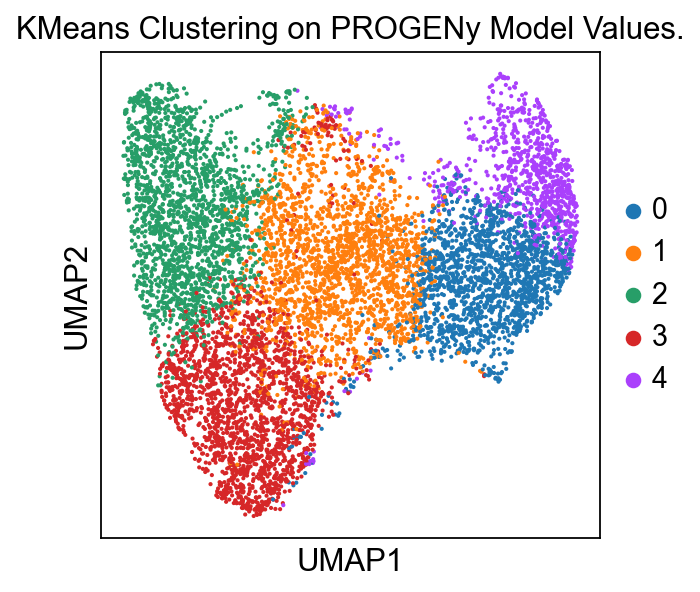

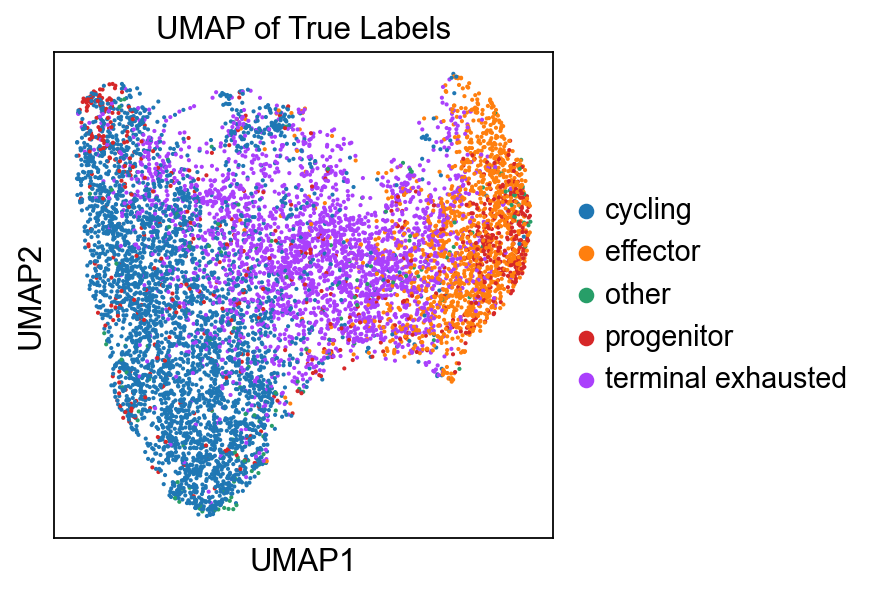

In [16]:
from sklearn.cluster import KMeans
import umap.umap_ as umap


acts = decoupler.get_acts(non_empty_features, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PROGENy Model Values.")
sc.pl.umap(adata, color=["state"], title="UMAP of True Labels")

### Cluster Results

In [17]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

#Special accuracy function.
print(f"Special accuracy: {acc(adata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4}), kmeans.labels_)}")
'''
Silhouette Score: 0.10964662581682205
Calinski-Harabasz Index: 4611.1675632659235
Dunn Index: 0.04010670817222
0.43809457434575044
CPU times: total: 50.9 s
Wall time: 3min 44s

Silhouette Score: 0.10784872621297836
Calinski-Harabasz Index: 915.0039931963461
Dunn Index: 0.056072799197753806
Special accuracy: 0.4460707440320613
CPU times: total: 1.33 s
Wall time: 1.33 s

Silhouette Score: 0.1406594216823578
Calinski-Harabasz Index: 1264.6453096698822
Dunn Index: 0.0738300356213624
Special accuracy: 0.47255619445896496

Silhouette Score: 0.1678408831357956
Calinski-Harabasz Index: 1395.0839375526796
Dunn Index: 0.0664913042207824
Special accuracy: 0.527443805541035

Silhouette Score: 0.31864112615585327 (without normalization)
Calinski-Harabasz Index: 2969.8387111963275
Dunn Index: 0.010613224810574452
Special accuracy: 0.6354765638612999

Silhouette Score: 0.2656403183937073 (with normalization)
Calinski-Harabasz Index: 4772.814948414939
Dunn Index: 0.01198932258659006
Special accuracy: 0.4913748039728176
'''

Silhouette Score: 0.15171657502651215
Calinski-Harabasz Index: 2125.3399848974664
Dunn Index: 0.06125820192611736
Special accuracy: 0.48170519224067837
CPU times: total: 3.25 s
Wall time: 2.95 s


'\nSilhouette Score: 0.10964662581682205\nCalinski-Harabasz Index: 4611.1675632659235\nDunn Index: 0.04010670817222\n0.43809457434575044\nCPU times: total: 50.9 s\nWall time: 3min 44s\n\nSilhouette Score: 0.10784872621297836\nCalinski-Harabasz Index: 915.0039931963461\nDunn Index: 0.056072799197753806\nSpecial accuracy: 0.4460707440320613\nCPU times: total: 1.33 s\nWall time: 1.33 s\n\nSilhouette Score: 0.1406594216823578\nCalinski-Harabasz Index: 1264.6453096698822\nDunn Index: 0.0738300356213624\nSpecial accuracy: 0.47255619445896496\n\nSilhouette Score: 0.1678408831357956\nCalinski-Harabasz Index: 1395.0839375526796\nDunn Index: 0.0664913042207824\nSpecial accuracy: 0.527443805541035\n\nSilhouette Score: 0.31864112615585327 (without normalization)\nCalinski-Harabasz Index: 2969.8387111963275\nDunn Index: 0.010613224810574452\nSpecial accuracy: 0.6354765638612999\n\nSilhouette Score: 0.2656403183937073 (with normalization)\nCalinski-Harabasz Index: 4772.814948414939\nDunn Index: 0.01